Next steps:
1. Add a "master node" that connects all nodes together, so that message passing works between all nodes

In [1]:
import pandas as pd

from EmbedDataset import LigandBinaryDataset

import time
import numpy as np
import torch
from torch_geometric.loader import DataLoader

In [2]:
dataset = LigandBinaryDataset('./data2/')

In [3]:
dataset = dataset.shuffle()
train_dataset = dataset[:int(len(dataset) * 0.7)]
val_dataset = dataset[int(len(dataset) * 0.7):int(len(dataset) * 0.85)]
test_dataset = dataset[int(len(dataset) * 0.85):]

In [4]:
train_dl = DataLoader(train_dataset, batch_size=16)
val_dl = DataLoader(val_dataset, batch_size=16)
test_dl = DataLoader(test_dataset, batch_size=16)

In [5]:
from LigandGNNV2 import LigandGNNV2
from LigandGNNV1 import LigandGNNV1
from sagn.models import SAGN

device = torch.device('cuda')
# model = LigandGNNV1(dataset.num_node_features, 1).to(device)
model = LigandGNNV2(128, 45).to(device)
# model = SAGN(in_feats=1070, hidden=1024, out_feats=1, num_hops=5, n_layers=2, num_heads=10).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([22]).to(device))

In [6]:
def train(model, loader, criterion, optimizer):
    model.train()

    loss_acc = 0.
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        label = data.y

        loss = criterion(output, label.reshape(-1, 1))
        loss.backward()
        loss_acc += data.num_graphs * loss.item()
        optimizer.step()

    return loss_acc / len(loader.dataset)

In [7]:
from sklearn.metrics import f1_score, precision_recall_curve, roc_curve, auc, precision_recall_fscore_support, roc_auc_score

def evaluate(model, loader):
    model.eval()

    preds = np.asarray([])
    labels = np.asarray([])

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            pred = torch.sigmoid(model(data).round().squeeze().cpu()).round().numpy()
            label = data.y.cpu().numpy()

            preds = np.concatenate([preds, pred])
            labels = np.concatenate([labels, label])

    precision, recall, _ = precision_recall_curve(labels, preds)
    fpr, tpr, thresholds = roc_curve(labels, preds, pos_label=1)
    print(precision_recall_fscore_support(labels, preds))
    return auc(fpr, tpr), auc(recall, precision)
    return roc_auc_score(labels, preds)

In [8]:
train_hist = []
val_hist = []

for epoch in range(1, 201):
    s = time.time()
    loss = train(model, train_dl, criterion, optimizer)
    train_score = evaluate(model, train_dl)
    val_score = evaluate(model, val_dl)
    scheduler.step(loss)
    e = time.time()

    train_hist.append(train_score)
    val_hist.append(val_score)

    if sum(val_score) > (.77 + .44) and sum(val_score) >= np.asarray(val_hist).sum(axis=1).max():
        print("saving...")
        torch.save(model.state_dict(), './models/BestModel4.pt')

    # print(f'Epoch: {epoch:03d}, Loss: {loss:.05f}, Train Score: {train_score:.05f}, Val Score: {val_score:.05f}, Time: {e - s:.05f}s')
    print(f'Epoch: {epoch:03d}, Loss: {loss:.05f}, Train Score: {train_score}, Val Score: {val_score}, Time: {e - s:.05f}s')

C:\Users\billb\anaconda3\envs\watai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.96599956, 0.        ]), array([1., 0.]), array([0.98270578, 0.        ]), array([336334,  11838], dtype=int64))


C:\Users\billb\anaconda3\envs\watai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.96236352, 0.        ]), array([1., 0.]), array([0.98082084, 0.        ]), array([72363,  2830], dtype=int64))
Epoch: 001, Loss: 1.19197, Train Score: (0.5, 0.5170002182829176), Val Score: (0.5, 0.5188182410596731), Time: 17.17372s
(array([0.98593729, 0.09878442]), array([0.78045039, 0.68373036]), array([0.87124152, 0.17262781]), array([336334,  11838], dtype=int64))
(array([0.98412362, 0.10399612]), array([0.77008969, 0.68233216]), array([0.86404937, 0.18048416]), array([72363,  2830], dtype=int64))
Epoch: 002, Loss: 1.04007, Train Score: (0.7320903727433279, 0.39663404140073144), Val Score: (0.7262109210976911, 0.3991420889941815), Time: 13.03200s
(array([0.9848014 , 0.12765628]), array([0.84901913, 0.62772428]), array([0.91188338, 0.21216577]), array([336334,  11838], dtype=int64))
(array([0.98227007, 0.13404305]), array([0.84599865, 0.60954064]), array([0.90905581, 0.21975922]), array([72363,  2830], dtype=int64))
Epoch: 003, Loss: 0.95314, Train Score: (0.738371703771609,

KeyboardInterrupt: 

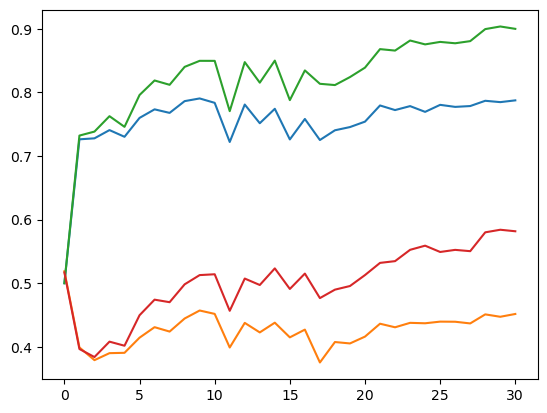

In [9]:
import matplotlib.pyplot as plt
plt.plot(val_hist)
plt.plot(train_hist)
plt.show()

In [10]:
evaluate(model, test_dl)

(array([0.98767828, 0.20123944]), array([0.90045636, 0.69064192]), array([0.94205272, 0.31166565]), array([71215,  2586], dtype=int64))


(0.7955491412750264, 0.4513606580789816)

In [12]:
torch.save(model.state_dict(), 'models/BestModel5.pt')

In [13]:
model.load_state_dict(torch.load('./models/BestModel4.pt'))
evaluate(model, test_dl)

(array([0.99024536, 0.14775921]), array([0.83818016, 0.77262181]), array([0.90788933, 0.24807549]), array([71215,  2586], dtype=int64))


(0.8054009842096082, 0.46417419433923857)

In [ ]:
data = test_dl.dataset[4].to(device)

In [ ]:
pred = model(data)

In [ ]:
out = torch.sigmoid(pred).round()
out

In [ ]:
print(out.sum())
print(len(out))

In [ ]:
len(data.y) / data.y.sum()

In [ ]:
data.y.sum()

In [ ]:
f1_score(data.y.detach().cpu().numpy(), out.detach().cpu().numpy())

In [ ]:
torch.save(model.state_dict(), './models/modelBest.pt')